# Car speed over time

In this part of the project the development of the speed of the cars will be investigated to answer the question: How much quicker did the cars get over time?

For this the following points will be investigated using the data that was prepared in the previous part:
- How much quicker did the fastest cars get in qualifying?
- How much quicker did the fastest cars get in the race?

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("F1") \
    .getOrCreate()

25/05/28 21:57:46 WARN Utils: Your hostname, bdlc-004 resolves to a loopback address: 127.0.1.1; using 10.176.129.6 instead (on interface ens192)
25/05/28 21:57:46 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/28 21:57:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


As a first step all the necessary datasets will be loaded and shown how they look like.

In [2]:
circuits_df = spark.read.parquet(f"/f1/data/cleaned_circuits.parquet")
lap_times_df = spark.read.parquet(f"/f1/data/cleaned_lap_times.parquet")
races_df = spark.read.parquet(f"/f1/data/cleaned_races.parquet")
qualifying_df = spark.read.parquet(f"/f1/data/cleaned_qualifying.parquet")
weather_df = spark.read.parquet(f"/f1/data/cleaned_weather.parquet")
results_df = spark.read.parquet(f"/f1/data/cleaned_results.parquet")

In [3]:
circuits_df.show(1)
lap_times_df.show(1)
races_df.show(1)
qualifying_df.show(1)
results_df.show(1)
weather_df.show(1)

+---------+-----------+--------------------+
|circuitId| circuitRef|                name|
+---------+-----------+--------------------+
|        1|albert_park|Albert Park Grand...|
+---------+-----------+--------------------+
only showing top 1 row

+------+------------+
|raceId|milliseconds|
+------+------------+
|   162|       87990|
+------+------------+
only showing top 1 row

+------+---------+----+-----+--------------------+----------+----------+
|raceId|circuitId|year|round|                name|      date|quali_date|
+------+---------+----+-----+--------------------+----------+----------+
|     1|        1|2009|    1|Australian Grand ...|2009-03-29|        \N|
+------+---------+----+-----+--------------------+----------+----------+
only showing top 1 row

+---------+------+--------+-------------+--------+--------+--------+--------+
|qualifyId|raceId|driverId|constructorId|position|      q1|      q2|      q3|
+---------+------+--------+-------------+--------+--------+--------+----

Now we prepare a dataframe which will be the basis for the rest of this analysis.
The dataset should contain all races with the following information:
- The `year` and the `round`: Makes each race uniquely identifyable
- The `fastest_race_lap`: The minimal lap time over all the laps driven during a race
- The `fastest_qualifying_lap`: The minimal lap time over all qualifying sessions of a race
- The `fastest_lap`: The overall minimal lap time of a race weekend (race and qualifying).
- Circuit Information: Lap times are circuit specific, therefore we must b

In [13]:
from pyspark.sql import functions as f
from pyspark.sql.window import Window
from pyspark.sql.types import LongType
import matplotlib.pyplot as plt

def time_to_ms(time_str):
    """
    Converts mm:ss.SSS to milliseconds
    """
    if time_str == "\\N":
        return None
    minutes, sec_ms = time_str.split(':')
    seconds, ms = sec_ms.split('.')
    minutes = int(minutes)
    seconds = int(seconds)
    milliseconds = float(ms)
    return int((minutes * 60 * 1000) + (seconds * 1000) + milliseconds)
time_to_ms_udf = f.udf(time_to_ms, LongType())

fastest_laps = lap_times_df.groupBy("raceId").agg(f.min("milliseconds").alias("fastest_lap"))
qualifying_with_min = qualifying_df.withColumn("min_q_time", f.least(f.col("q1"), f.col("q2"), f.col("q3")))
fastest_qualifying = qualifying_with_min.groupBy("raceId") \
    .agg(f.min("min_q_time").alias("fastest_qualifying")) \
    .withColumn("fastest_qualifying", time_to_ms_udf(f.col("fastest_qualifying")))
races_with_year = races_df.select("raceId", "year", "round", "circuitId").join(fastest_qualifying, "raceId")
fastest_laps_with_year = fastest_laps.join(races_with_year, "raceId")

speed_development = fastest_laps_with_year.groupBy("circuitId", "year", "round") \
    .agg(
            f.min(f.least("fastest_lap", "fastest_qualifying")).alias("fastest_lap"),
            f.min("fastest_qualifying").alias("fastest_qualifying"),
            f.min("fastest_lap").alias("fastest_race_lap"),
        )
circuits_with_name = circuits_df.select("circuitId", "circuitRef", "name")
speed_development = speed_development.join(circuits_with_name, "circuitId")
speed_development.show(5)


+---------+----+-----+-----------+------------------+----------------+-----------+--------------------+
|circuitId|year|round|fastest_lap|fastest_qualifying|fastest_race_lap| circuitRef|                name|
+---------+----+-----+-----------+------------------+----------------+-----------+--------------------+
|       18|2009|   16|      73733|             79576|           73733| interlagos|Autódromo José Ca...|
|       17|2018|    3|      91095|             91095|           95785|   shanghai|Shanghai Internat...|
|       71|2021|   15|      97423|            101993|           97423|      sochi|      Sochi Autodrom|
|        9|2010|   10|      89615|             89615|           90874|silverstone| Silverstone Circuit|
|       22|2015|   14|      92584|             92584|           96145|     suzuka|      Suzuka Circuit|
+---------+----+-----+-----------+------------------+----------------+-----------+--------------------+
only showing top 5 rows



Let's quickly analyse the `speed_development` dataset which will be used from now on.

In [14]:
speed_development.summary().show()

+-------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------+--------------------+
|summary|         circuitId|              year|            round|       fastest_lap|fastest_qualifying|  fastest_race_lap| circuitRef|                name|
+-------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------+--------------------+
|  count|               462|               462|              462|               462|               462|               462|        462|                 462|
|   mean|20.393939393939394|2012.8290043290044|9.993506493506494| 84986.25757575757| 85512.19696969698| 88360.56060606061|       NULL|                NULL|
| stddev|21.724677483898343| 7.446627349098165|5.830390222851038|10848.236136637332|11366.913446277988|12721.062285944123|       NULL|                NULL|
|    min|                 1|              1996|                1

One thing that sticks out is that the minimal value for `year` is `1996` and not the expected `1950`. \
This is due to the fact that the dataset only contains lap time values since then.
Therefore, all the analysis will be done between **1996-2024**.

## Fastest Lap Times Of All Circuits Continously Driven Over The Last 10 Years

Before we dive deeper into the data, let's have a look how much F1 Cars evolved over the last 10 years by just plotting the dataframe
grouped by the circuits.

Here, the Fastest Lap Time is the minimal time from both the Qualifying and Race.

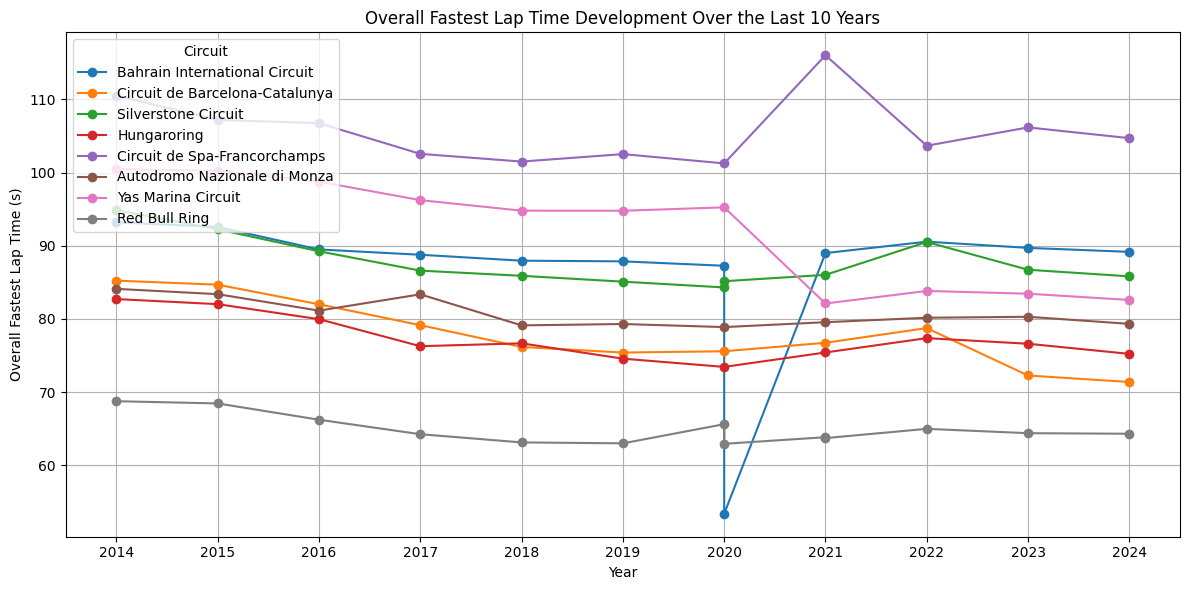

In [6]:
current_year = 2024
include_last_x_years = 10
last_x_years = speed_development.filter(f.col("year") >= current_year - include_last_x_years)

speed_development_pd = last_x_years.toPandas()
num_years_required = include_last_x_years + 1
grouped = speed_development_pd.groupby('circuitId').filter(
    lambda x: x['year'].nunique() == num_years_required
).groupby('circuitId')

fig, ax = plt.subplots(figsize=(12, 6))

for circuit_id, group in grouped:
    group = group.sort_values(by='year')
    ax.plot(group['year'], group['fastest_lap'] / 1000, marker='o', label=group['name'].iloc[0])

ax.set_title(f'Overall Fastest Lap Time Development Over the Last {include_last_x_years} Years')
ax.set_xlabel('Year')
ax.set_ylabel('Overall Fastest Lap Time (s)')
# Ensure all years in the range are shown as ticks
ax.set_xticks(list(range(current_year - include_last_x_years, current_year + 1)))
ax.grid(True)
ax.legend(title='Circuit', loc='upper left') # Adjust legend position

plt.tight_layout()
plt.show()

**Observations:**

> NOTE on 2020: There are a lot of duplicate entries for this year. This is not an error in the data, but rather due to COVID-19 which lead to multiple races on the same circuit.

While most Laptimes are slightly decreasing over the years as expected, there are a few datapoints sticking out:
1. **Spa 2021**: The big spike in the fastest laptime is due to heavy rain in both qualifying and the race.
1. **Baharin 2020**: The fastest lap time was much quicker because the second race on the same circuit was held on the shorter and faster Bahrain Outer Circuit instead of the traditional layout.
1. **Yas Marina 2021**: The track was redesigned, leading to a faster lap time due to a reduced number of slow-speed corners.

## Investigate specific circuits over the years

Some circuits didn't change a lot over time, lets use them to visually compare the lap times. \
Since we only have lap time data since 1996, the analysis is limited to the time frame between 1996 - 2024.

For each selected circuit, the plots show:
- The Fastest Qualifying Lap (Q1, Q2 and Q3 combined)
- The Fastest Race Lap
- A Trendline using the overall fastest lap of a race weekend

Showing multiple lap times from different days (Qualifying and Race) allows to more easily spot if there were bad weather conditions on one of the two days. \
If both events had especially bad weather conditions, they will be listed in the observations below.

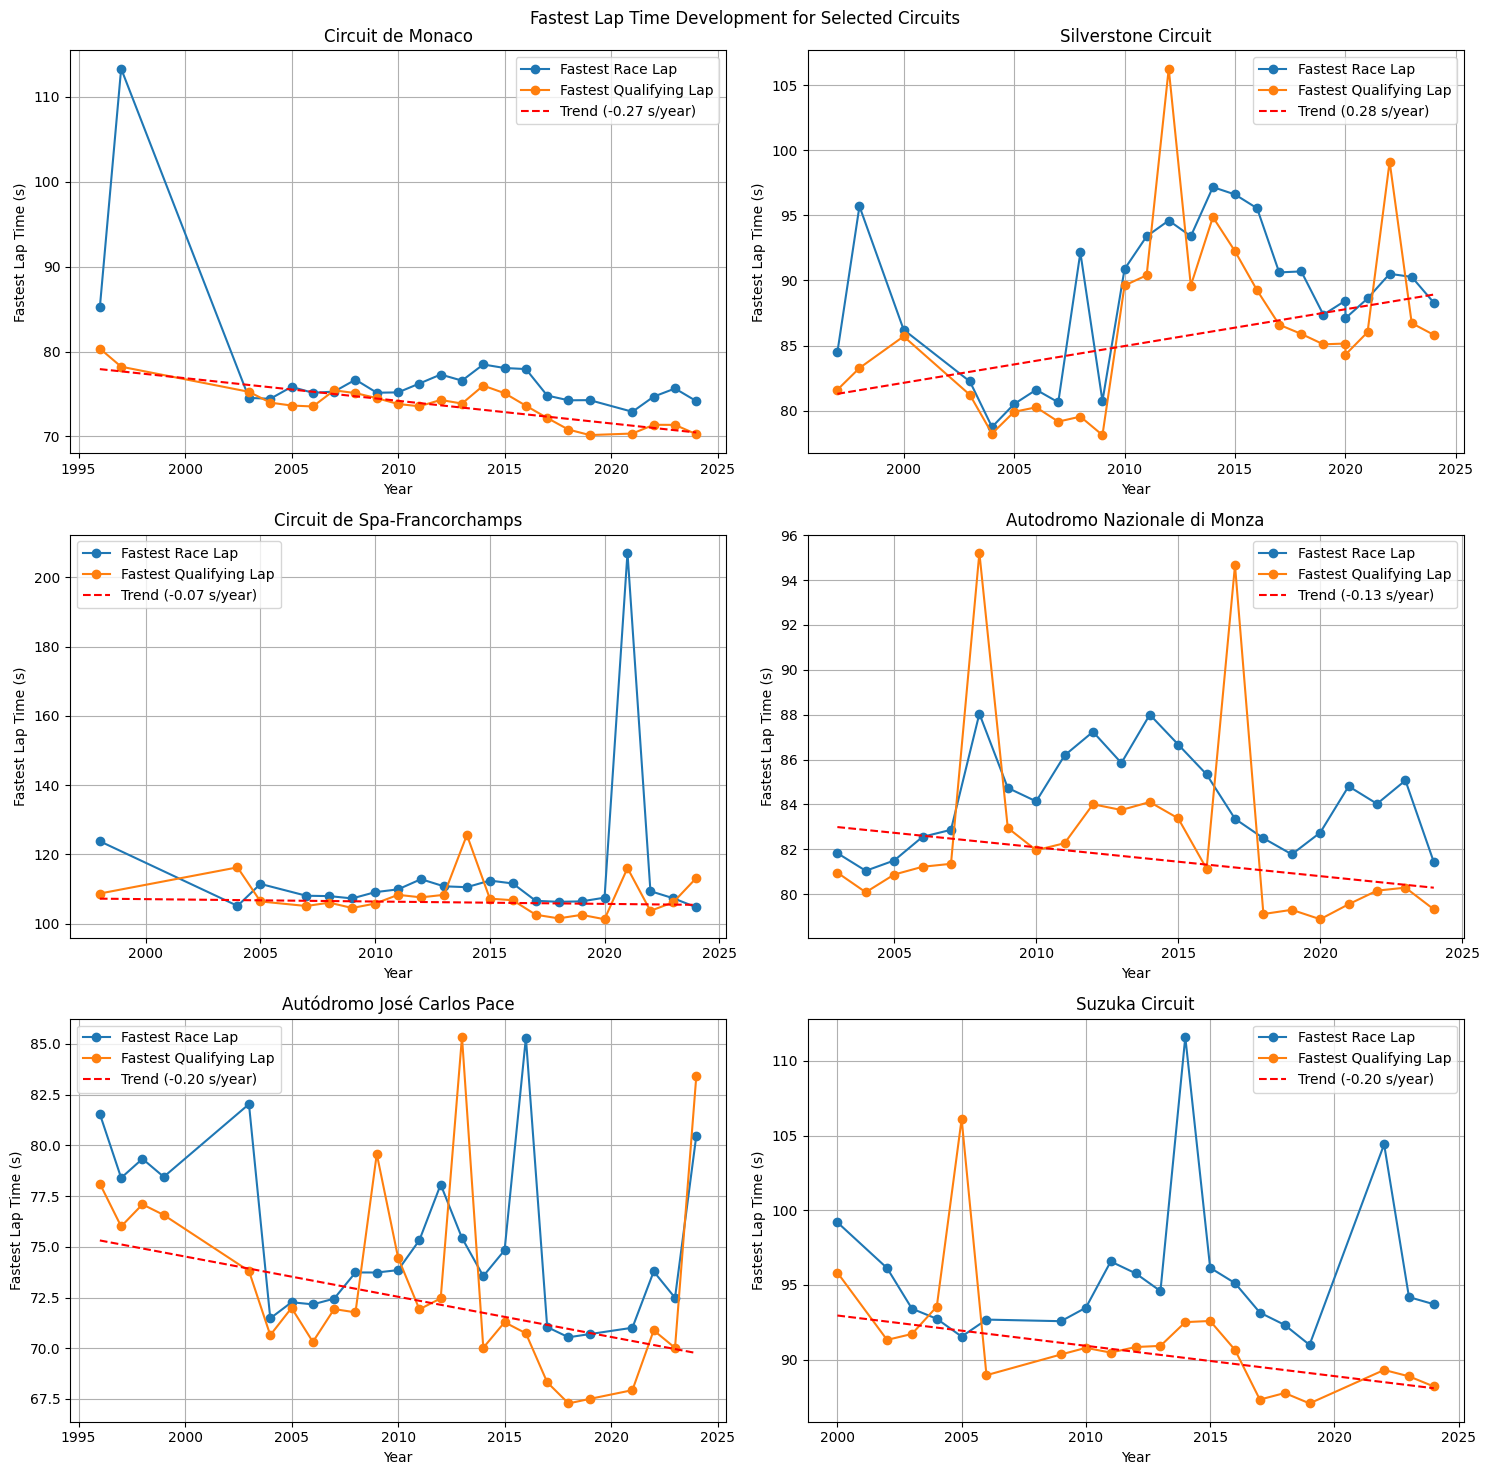

In [7]:
import numpy as np

circuits = ['monza', 'monaco', 'interlagos', 'spa', 'silverstone', 'suzuka']
selected_circuits_df = speed_development.filter(f.col("circuitRef").isin(circuits))
grouped_circuits_pandas_df = selected_circuits_df.toPandas().groupby('circuitId')

num_circuits = grouped_circuits_pandas_df.ngroups
ncols = 2
nrows = (num_circuits + ncols - 1) // ncols
fig_multi, axes_multi = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows))
axes_multi = axes_multi.flatten()

for i, (circuit_id, group) in enumerate(grouped_circuits_pandas_df):
    ax = axes_multi[i]
    group = group.sort_values(by='year')
    circuit_name = group['name'].iloc[0]
    ax.plot(group['year'], group['fastest_race_lap'] / 1000, marker='o', label='Fastest Race Lap')
    ax.plot(group['year'], group['fastest_qualifying'] / 1000, marker='o', label='Fastest Qualifying Lap')

    # Linear Regression
    x = group['year']
    y = group['fastest_lap'] / 1000
    slope, intercept = np.polyfit(x, y, 1)
    line_x = np.array([x.min(), x.max()])
    line_y = slope * line_x + intercept
    ax.plot(line_x, line_y, color='red', linestyle='--', label=f'Trend ({slope:.2f} s/year)')

    ax.set_title(circuit_name)
    ax.set_xlabel('Year')
    ax.set_ylabel('Fastest Lap Time (s)')
    ax.grid(True)
    ax.legend(loc='best')


plt.suptitle('Fastest Lap Time Development for Selected Circuits')
plt.tight_layout()
plt.show()


The trend shows most circuits get between 0.1 - 0.3 seconds faster per year. However, there are some outliers influencing the trendlines:
- **Silverstone** underwent significant layout changes between **2010 and 2011**, leading to much slower lap times from then on.
- **Spa 2021**, **Monza 2008** and **Jose Carlos 2024** all had heavy rain during both Qualifying and the Race, leading to much slower overall lap times.

## Fastest Qualifying Lap Time Difference: Then vs Now

The goal of this section is to answer the first question:
> How much quicker did the fastest cars get in qualifying?

If we would just compare the fastest laps for the circuits raced in 1996 and 2024 and look at the difference, it would not be very percise.
If there was really bad weather in a race in 2024, the lap times might actually be worse than the ones from 1996.

To mitigate this, we take the lap times between 1996 and 2001 and compare them to the fastest lap times between 2019 and 2024 for each circuit that has been raced during this peroid.
By comparing a range of years together, we reduce the impact of outliers and focus on the general trend of lap times.

Some circuits are hard to compare, as they have been modified over the years. To mitigate the impact of this, we will use the median lap time difference to answer the question.

In [8]:
from pyspark.sql import Window
from pyspark.sql import functions as f

old_period = (1996, 2001)
recent_period = (2019, 2024)
old_period_df = speed_development.filter(f"year >= {old_period[0]} AND year <= {old_period[1]}").withColumn("period", f.lit("old"))
recent_period_df = speed_development.filter(f"year >= {recent_period[0]} AND year <= {recent_period[1]}").withColumn("period", f.lit("recent"))
combined_df = old_period_df.unionByName(recent_period_df)

# Only get the fastest qualifying time for each circuit in each period
fastest_times_df = combined_df.withColumn("rowNr", f.row_number().over(
    Window.partitionBy("circuitId", "period").orderBy(f.col("fastest_qualifying").asc())
)) \
    .filter(f.col("rowNr") == 1) \
    .select("circuitId", "name", "year", "fastest_qualifying", "period")

# Pivot to get old and recent period times in separate columns
qualifying_comparison_df = fastest_times_df.groupBy("circuitId", "name") \
    .pivot("period", ["old", "recent"]) \
    .agg(
        f.first("year").alias("year"),
        f.first("fastest_qualifying").alias("q_time")
    ).filter(f.col("old_q_time").isNotNull() & f.col("recent_q_time").isNotNull())


final_q_comparison_df = qualifying_comparison_df.withColumn(
    "q_time_difference_s", (f.col("old_q_time") - f.col("recent_q_time")) / 1000
).select(
    "name",
    f.concat(f.col("old_year"), f.lit("-"), f.col("recent_year")).alias("Compared Years"),
    f.round((f.col("old_q_time") / 1000), 1).alias(f"({old_period[0]}-{old_period[1]}) Fastest Qualifying (s)"),
    f.round((f.col("recent_q_time") / 1000), 1).alias(f"({recent_period[0]}-{recent_period[1]}) Fastest Qualifying (s)"),
    f.round((f.col("q_time_difference_s") / (f.col("recent_year") - f.col("old_year"))), 1).alias("Qualifying Difference (s/year)"),
    f.round(f.col("q_time_difference_s"), 1).alias("Qualifying Difference (s)")
).orderBy(f.desc("q_time_difference_s"))

final_q_comparison_df.show()

+--------------------+--------------+----------------------------------+----------------------------------+------------------------------+-------------------------+
|                name|Compared Years|(1996-2001) Fastest Qualifying (s)|(2019-2024) Fastest Qualifying (s)|Qualifying Difference (s/year)|Qualifying Difference (s)|
+--------------------+--------------+----------------------------------+----------------------------------+------------------------------+-------------------------+
|      Hockenheimring|     1998-2019|                             101.8|                              71.8|                           1.4|                     30.1|
|       Red Bull Ring|     1998-2020|                              89.6|                              62.9|                           1.2|                     26.7|
|Albert Park Grand...|     1997-2024|                              89.4|                              75.9|                           0.5|                     13.5|
|Autodromo

In [9]:
median_diff = final_q_comparison_df.approxQuantile("Qualifying Difference (s)", [0.5], 0.01)
print(f"Median Qualifying Time Difference (s): {median_diff[0]} ({median_diff[0] / (recent_period[0] - old_period[0]):.2f} seconds per year)")

Median Qualifying Time Difference (s): 8.1 (0.35 seconds per year)


## Fastest Race Lap Time Difference: Then vs Now

Similar to the section above, we will answer the second question here:
> How much quicker did the fastest cars get in the race?

In [10]:
# Only get the fastest race time for each circuit in each period
fastest_race_times_df = combined_df.withColumn("rowNr", f.row_number().over(
    Window.partitionBy("circuitId", "period").orderBy(f.col("fastest_race_lap").asc())
)) \
    .filter(f.col("rowNr") == 1) \
    .select("circuitId", "name", "year", "fastest_race_lap", "period")

# Pivot to get old and recent period times in separate columns
race_lap_comparison_df = fastest_race_times_df.groupBy("circuitId", "name") \
    .pivot("period", ["old", "recent"]) \
    .agg(
        f.first("year").alias("year"),
        f.first("fastest_race_lap").alias("lap_time")
    ).filter(f.col("old_lap_time").isNotNull() & f.col("recent_lap_time").isNotNull())


final_lap_comparison_df = race_lap_comparison_df.withColumn(
    "lap_time_difference_s", (f.col("old_lap_time") - f.col("recent_lap_time")) / 1000
).select(
    "name",
    f.concat(f.col("old_year"), f.lit("-"), f.col("recent_year")).alias("Compared Years"),
    f.round((f.col("old_lap_time") / 1000), 1).alias(f"({old_period[0]}-{old_period[1]}) Fastest Lap (s)"),
    f.round((f.col("recent_lap_time") / 1000), 1).alias(f"({recent_period[0]}-{recent_period[1]}) Fastest Lap (s)"),
    f.round((f.col("lap_time_difference_s") / (f.col("recent_year") - f.col("old_year"))), 1).alias("Lap Difference (s/year)"),
    f.round(f.col("lap_time_difference_s"), 1).alias("Lap Difference (s)")
).orderBy(f.desc("lap_time_difference_s"))

final_lap_comparison_df.show()

+--------------------+--------------+---------------------------+---------------------------+-----------------------+------------------+
|                name|Compared Years|(1996-2001) Fastest Lap (s)|(2019-2024) Fastest Lap (s)|Lap Difference (s/year)|Lap Difference (s)|
+--------------------+--------------+---------------------------+---------------------------+-----------------------+------------------+
|      Hockenheimring|     1997-2019|                      105.7|                       76.6|                    1.3|              29.1|
|Circuit de Spa-Fr...|     1998-2024|                      123.8|                      104.7|                    0.7|              19.1|
|   Circuit de Monaco|     1996-2021|                       85.2|                       72.9|                    0.5|              12.3|
|Albert Park Grand...|     1997-2024|                       90.6|                       79.8|                    0.4|              10.8|
|Autodromo Enzo e ...|     1997-2020|    

In [11]:
median_diff = final_lap_comparison_df.approxQuantile("Lap Difference (s)", [0.5], 0.01)
print(f"Median Lap Time Difference (s): {median_diff[0]} ({median_diff[0] / (recent_period[0] - old_period[0]):.2f} seconds per year)")

Median Lap Time Difference (s): 7.7 (0.33 seconds per year)


## Conclusion

Answering the question about how much faster F1 cars got (between 1996 - 2024) is not that trivial, since there are tons of factors influencing how fast an F1 car is on a given day.
However, it's clearly visible that the cars have gotten much faster over the years.

The median time difference between the qualifying and race is quite similar (8.1 and 7.7 seconds).
This is expected, since even though cars are generally slower in the race compared to qualifying,
there is no obvious reason why the difference of how much slower they are would change over the years.   



# Additional: Highlight Rainy Races (2018 - 2023)

The weather dataset contains infos about the rain during races between 2018 - 2023. \
Let's try to use this data to make it more visible which role the rain plays for the fastest race lap. \
For a better comparison, the fastest qualifying lap for each race is also displayed.

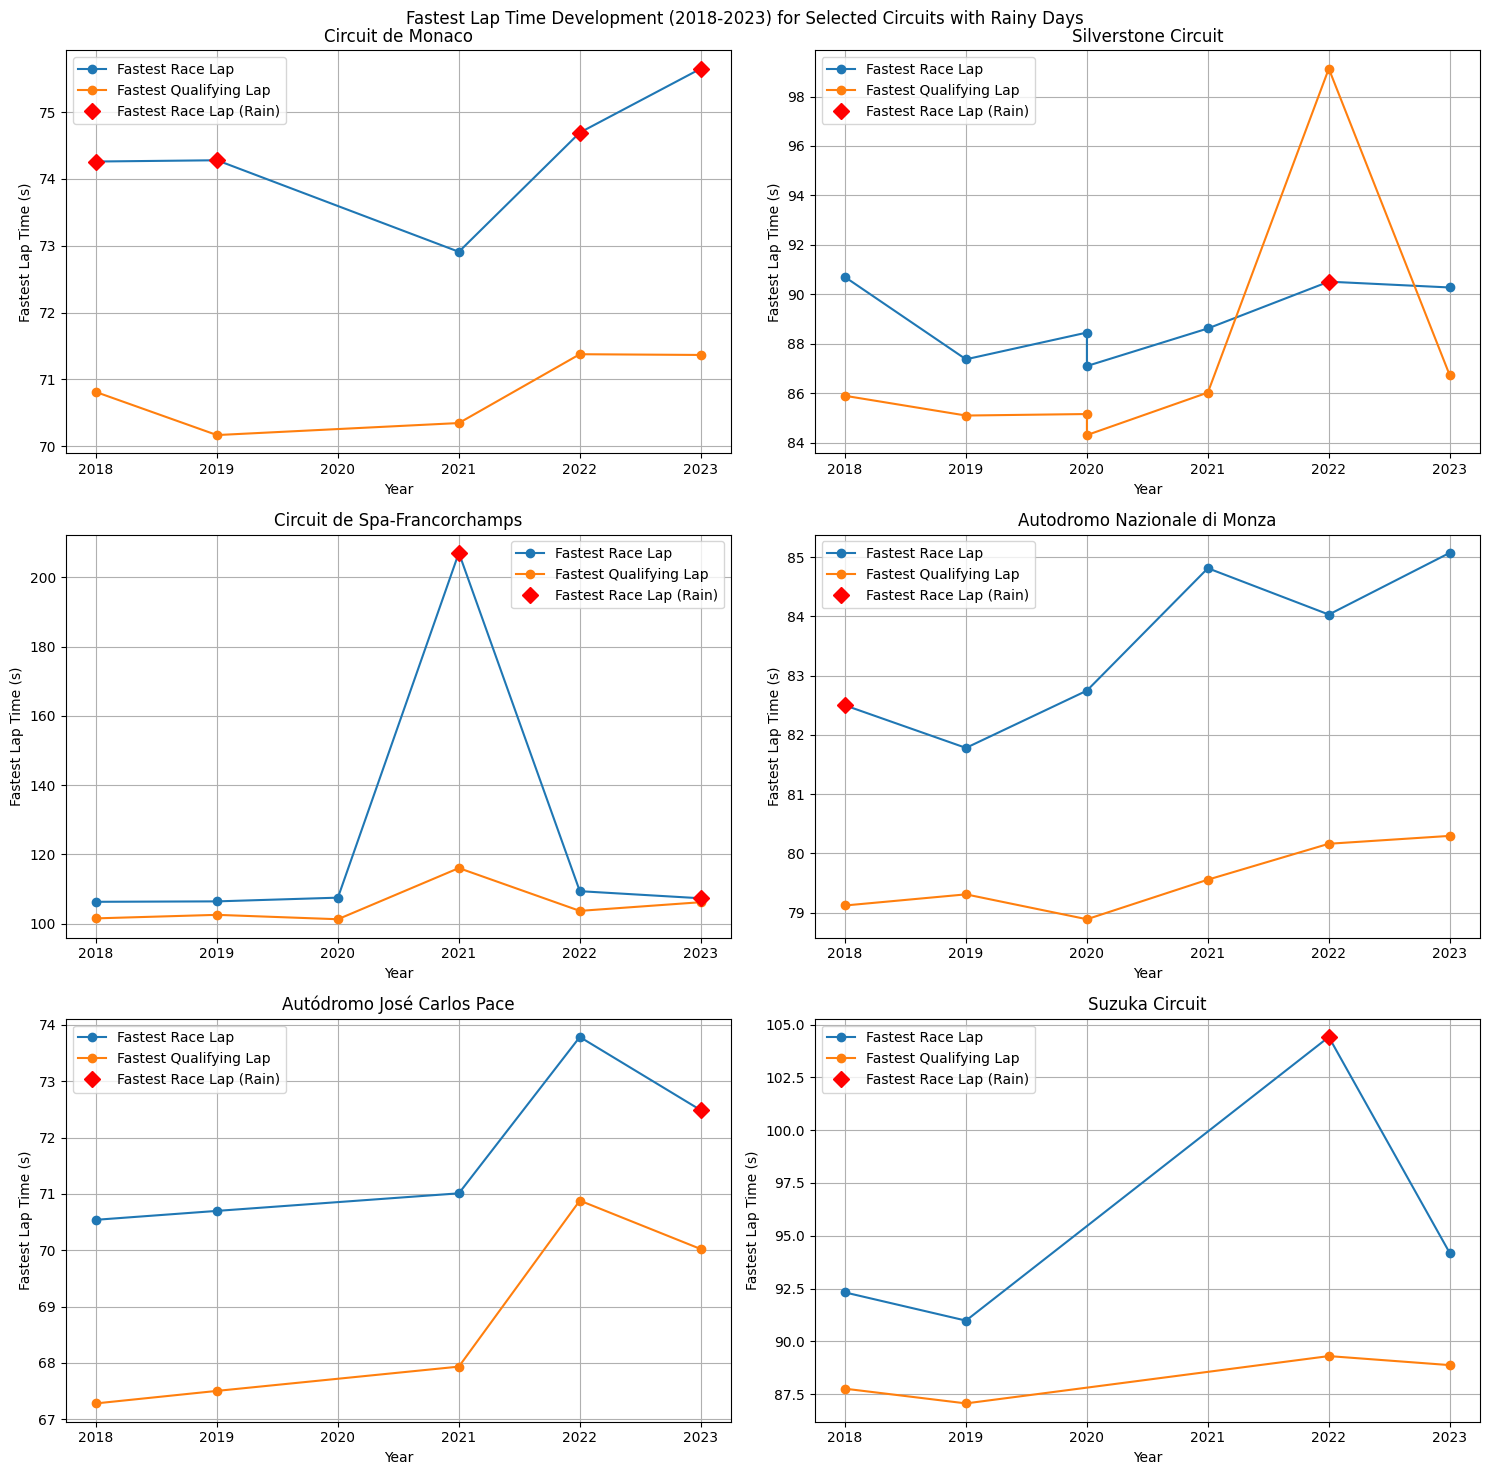

In [12]:
import numpy as np

circuits_without_rain = selected_circuits_df.join(weather_df, ["year", "round"])

fig_multi, axes_multi = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows))
axes_multi = axes_multi.flatten()

for i, (circuit_id, group) in enumerate(circuits_without_rain.toPandas().groupby("circuitId")):
    ax = axes_multi[i]
    group = group.sort_values(by='year')
    circuit_name = group['name'].iloc[0]
    ax.plot(group['year'], group['fastest_race_lap'] / 1000, marker='o', label='Fastest Race Lap')
    ax.plot(group['year'], group['fastest_qualifying'] / 1000, marker='o', label='Fastest Qualifying Lap')
    rainy_days = group[group['rain'] == True]
    if not rainy_days.empty:
        ax.plot(rainy_days['year'], rainy_days['fastest_race_lap'] / 1000, marker='D', markersize=8 ,linestyle='', color='red', label='Fastest Race Lap (Rain)')

    ax.set_title(circuit_name)
    ax.set_xlabel('Year')
    ax.set_ylabel('Fastest Lap Time (s)')
    ax.grid(True)
    ax.legend(loc='best')


plt.suptitle('Fastest Lap Time Development (2018-2023) for Selected Circuits with Rainy Days')
plt.tight_layout()
plt.show()

**Observations**

Each circuit has in common that it actually gets slower instead of quicker from 2022 on. \
This is due to new regulations introduces in 2022 which made the cars overall slower: https://www.motorsinside.com/en/f1/news/27513-the-2022-f1-cars-were-slower-than-2021-f1-cars.html

Other interesting observations:
1. Monaco: 2021 is the only time it didn't rain which lead to a 2.5 second faster race lap time compared to the other years.
1. Silverstone:
   - Between **2018 and 2019**, the fastest race lap was around 3 seconds quicker, with both races not having any rain. This is actually the result of car and tyre upgrades compared to the previous year.
   - The **Second Race of 2020** was 1.5 seconds slower than the first one a week before. The main reason is that they wanted to make the race more interesting by using harder tired compared to the previous weekend.
   - The **2022 Qualifying** was held in wet conditions, leading to a much slower lap time: https://en.wikipedia.org/wiki/2022_British_Grand_Prix#Qualifying 
1. Spa: Apart from 2021, the fastest lap times between 2018 - 2023 remained very consistent